아래와 같이 분석하였습니다. 

1. data 준비
   - train data와 test data를 합쳤습니다.
   - NA이 과도하게 많은 (cutoff 2000 적용) Column을 삭제하였습니다.
   - 숫자형 data중에 치우친 column은 log transformation하였습니다. (np.log1p)
   - 숫자형 data중에 NAN 는 column mean 값으로 대체하였습니다. 
   - 숫자형이 아닌 data는 단순하게 int8 type으로 변경하였습니다.
   
2. model 
   - coefficiency 상위 20개의 column을 선택하였습니다.
   - xgboost model을 사용하여 분석하였습니다.
    
3. 참고 자료 
http://shahramabyari.com/2015/12/21/data-preparation-for-predictive-modeling-resolving-skewness/

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

import operator

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
import xgboost as xgb

print("pandas version: %s" % pd.__version__)

import platform
print("python version: %s" % platform.python_version())

pandas version: 0.19.1
python version: 3.4.4


/root/anaconda3/envs/cntk-py34/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("../Data/Hourse_Price_Train.csv")
test = pd.read_csv("../Data/Hourse_Price_Test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print("train rows are %s and test rows are %s " % (len(train),len(test)))

train rows are 1460 and test rows are 1459 


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))
print("all_data rows are %s and all_data columns are %s" % (len(all_data), len(all_data.columns)))

all_data rows are 2919 and all_data columns are 79


In [5]:
cutoff = 2000

def select_nan(ls1, ls2, cutoff):
    nan_list =[]
    
    for i in range(ls1.shape[0]):
      if(ls1[i] > cutoff):
         nan_list.append(ls2[i])
            
    return nan_list

nan_column = select_nan(all_data.isnull().sum().values, all_data.columns.values,cutoff)
print("NAN is over than %s on each column %s " % (cutoff,nan_column))
print("all_data NAN on each column %s" % all_data.isnull().sum().values)
print(all_data.columns.values)
print("all_data on LotFrontage column %s" % all_data['LotFrontage'][:10])
print("all_data on Alley column %s" % all_data['Alley'][:10])

NAN is over than 2000 on each column ['Alley', 'PoolQC', 'Fence', 'MiscFeature'] 
all_data NAN on each column [   0    4  486    0    0 2721    0    0    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    1    1   24   23    0    0    0   81
   82   82   79    1   80    1    1    1    0    0    0    1    0    0    0
    0    2    2    0    0    0    0    1    0    2    0 1420  157  159  159
    1    1  159  159    0    0    0    0    0    0    0 2909 2348 2814    0
    0    0    1    0]
['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'OverallQual' 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'MasVnrArea'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF'
 'TotalBsmtSF' '

In [6]:
clean_data = all_data.drop(nan_column, 1)
print(clean_data.head())

   MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    11250   Pave      IR1         Lvl   
3          70       RL         60.0     9550   Pave      IR1         Lvl   
4          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope      ...      OpenPorchSF EnclosedPorch  \
0    AllPub    Inside       Gtl      ...               61             0   
1    AllPub       FR2       Gtl      ...                0             0   
2    AllPub    Inside       Gtl      ...               42             0   
3    AllPub    Corner       Gtl      ...               35           272   
4    AllPub       FR2       Gtl      ...               84             0   

  3SsnPorch ScreenPorch PoolArea  MiscVal  MoSold  YrSold  SaleType  \
0         0          

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc45e36ca58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fc45b834f28>]], dtype=object)

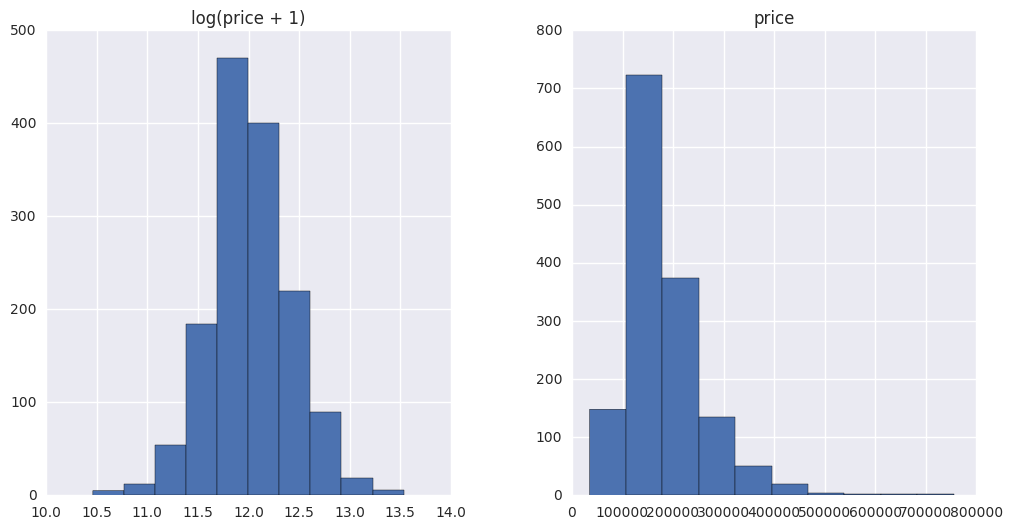

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

numeric data is Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object') 
skewed features in numeric data Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object') 


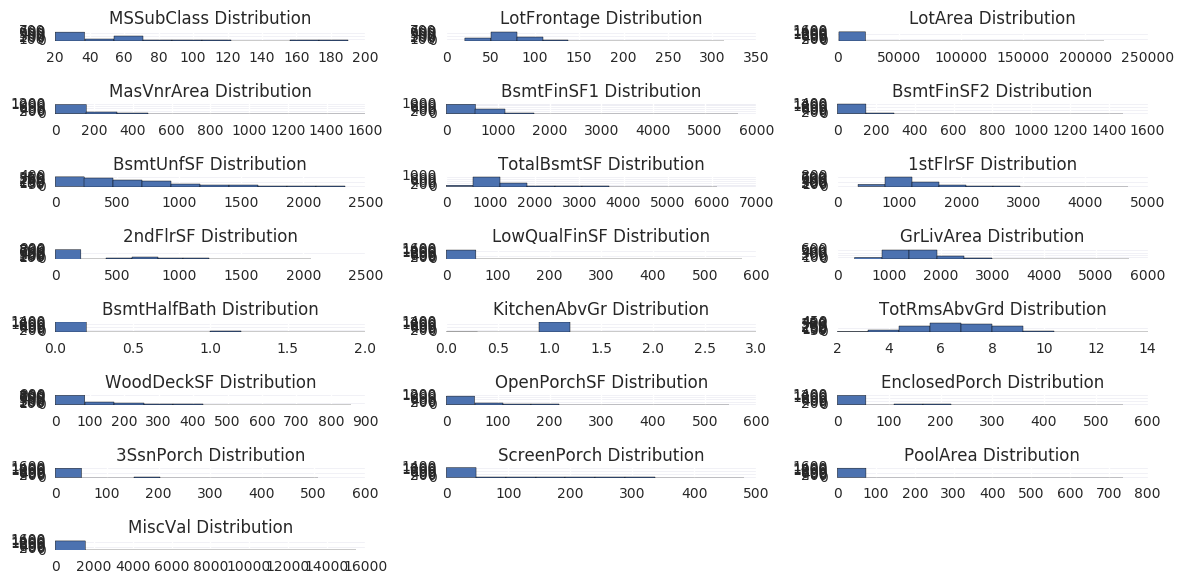

After log1p transformation


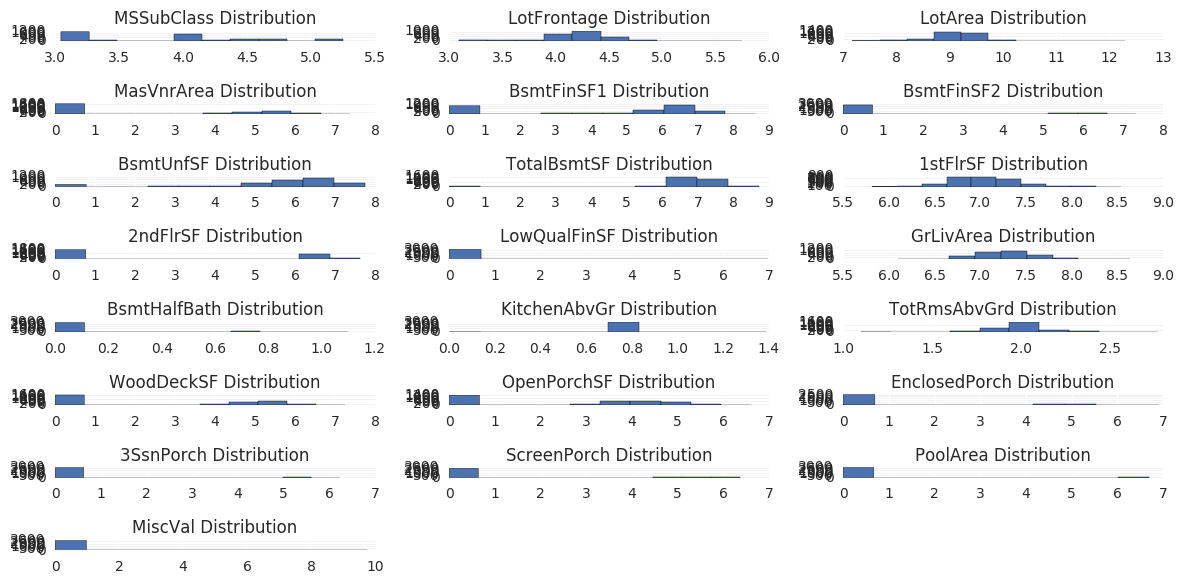

In [8]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = clean_data.dtypes[clean_data.dtypes != "object"].index

skewed_feats = clean_data[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

clean_data[skewed_feats] = np.log1p(clean_data[skewed_feats])

print("numeric data is %s " % numeric_feats)
print("skewed features in numeric data %s " % skewed_feats)

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        
#        print(type(df))
        
        if(isinstance(df, np.ndarray)):
          np.histogram(df, bins = range(5))
        
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(train[skewed_feats], train[skewed_feats].columns,8,3)
print("After log1p transformation")
draw_histograms(clean_data[skewed_feats], clean_data[skewed_feats].columns,8,3)

In [9]:
#group = all_data.columns.to_series().groupby(all_data.dtypes).groups

object_feats = clean_data.dtypes[clean_data.dtypes == "object"].index
float_feats = clean_data.dtypes[clean_data.dtypes == "float64"].index
int_feats = clean_data.dtypes[clean_data.dtypes == "int64"].index
non_object = clean_data.dtypes[clean_data.dtypes != "object"].index

print("clean_data data types are %s " % np.unique(clean_data.dtypes.values))
print("clean_data numeric_feats are %s" % non_object)
print("clean_data object_feats are %s" % object_feats)

clean_data data types are [dtype('int64') dtype('float64') dtype('O')] 
clean_data numeric_feats are Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')
clean_data object_feats are Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation

In [10]:
mean_data = clean_data[non_object].fillna(clean_data[non_object].mean())

print(clean_data.isnull().sum().values)
#print(clean_data[non_object][:30])
print(mean_data.isnull().sum().values)

[   0    4  486    0    0    0    0    2    0    0    0    0    0    0    0
    0    0    0    0    0    0    1    1   24   23    0    0    0   81   82
   82   79    1   80    1    1    1    0    0    0    1    0    0    0    0
    2    2    0    0    0    0    1    0    2    0 1420  157  159  159    1
    1  159  159    0    0    0    0    0    0    0    0    0    0    1    0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
temp_names = object_feats.values

for i in range(len(temp_names)):

    clean_data[temp_names[i]] = clean_data[temp_names[i]].astype('category')
    clean_data[temp_names[i]].cat.categories  

cat_list = []

for i in range(len(temp_names)):
    cat_list.append(clean_data[temp_names[i]].cat.codes)

cat_data = pd.concat(cat_list, axis=1)

cat_data.columns = object_feats.values

print(cat_data.head())
print(object_feats)
print(object_feats.values)

print(cat_data.isnull().sum().values)

   MSZoning  Street  LotShape  LandContour  Utilities  LotConfig  LandSlope  \
0         3       1         3            3          0          4          0   
1         3       1         3            3          0          2          0   
2         3       1         0            3          0          4          0   
3         3       1         0            3          0          0          0   
4         3       1         0            3          0          2          0   

   Neighborhood  Condition1  Condition2      ...        KitchenQual  \
0             5           2           2      ...                  2   
1            24           1           2      ...                  3   
2             5           2           2      ...                  2   
3             6           2           2      ...                  2   
4            15           2           2      ...                  2   

   Functional  FireplaceQu  GarageType  GarageFinish  GarageQual  GarageCond  \
0           6     

In [12]:
final_data = pd.concat([mean_data,cat_data], axis=1)
print(final_data.head())

   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    4.110874     4.189655  9.042040            7            5       2003   
1    3.044522     4.394449  9.169623            6            8       1976   
2    4.110874     4.234107  9.328212            7            5       2001   
3    4.262680     4.110874  9.164401            7            5       1915   
4    4.110874     4.442651  9.565284            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2      ...        \
0          2003    5.283204    6.561031         0.0      ...         
1          1976    0.000000    6.886532         0.0      ...         
2          2002    5.093750    6.188264         0.0      ...         
3          1970    0.000000    5.379897         0.0      ...         
4          2000    5.860786    6.486161         0.0      ...         

   KitchenQual  Functional  FireplaceQu  GarageType  GarageFinish  GarageQual  \
0            2           6         

In [13]:
y = train["SalePrice"]
log_y = np.log1p(train["SalePrice"])
print(y[:5])
print(log_y[:5])

#s1.loc['c':]

train_final = final_data.iloc[:1460]
test_final = final_data.iloc[1460:2900]

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64
0    2.583824
1    2.573300
2    2.589054
3    2.553297
4    2.597433
Name: SalePrice, dtype: float64


In [14]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_final, log_y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [15]:
model_ridge = Ridge()

In [16]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

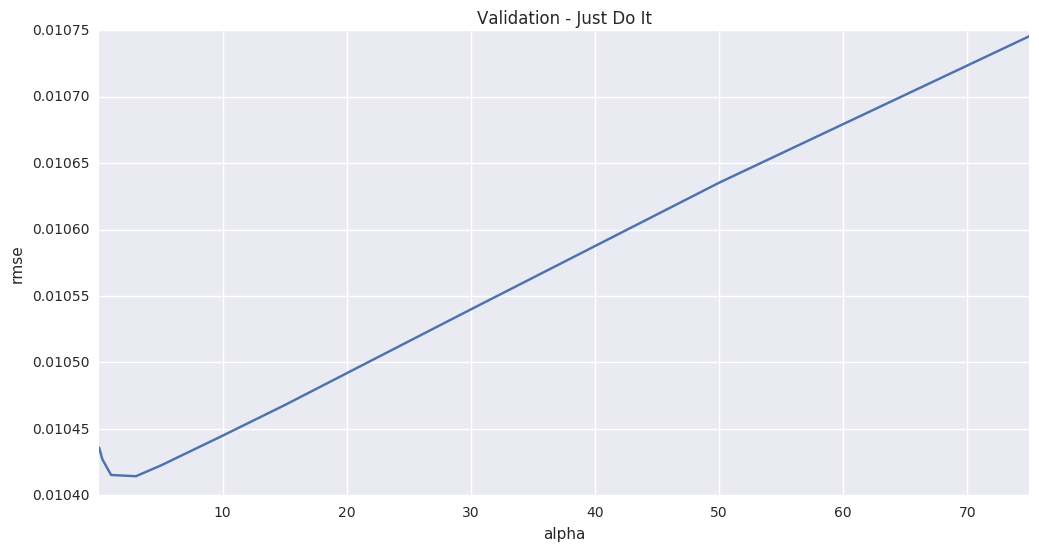

In [17]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [18]:
cv_ridge.min()

0.010414390324771454

In [19]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train_final, log_y)

In [20]:
rmse_cv(model_lasso).mean()

0.010800211096383497

In [21]:
coef = pd.Series(model_lasso.coef_, index = list(train_final.columns))
print(coef)

MSSubClass      -0.000000
LotFrontage      0.000000
LotArea          0.006064
OverallQual      0.006540
OverallCond      0.002691
YearBuilt        0.000205
YearRemodAdd     0.000114
MasVnrArea       0.000000
BsmtFinSF1       0.001051
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
TotalBsmtSF      0.001633
1stFlrSF         0.001783
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.021438
BsmtFullBath     0.000000
BsmtHalfBath    -0.000000
FullBath         0.000004
HalfBath         0.000000
BedroomAbvGr     0.000589
KitchenAbvGr    -0.000000
TotRmsAbvGrd     0.000000
Fireplaces       0.001266
GarageYrBlt     -0.000042
GarageCars       0.000015
GarageArea       0.000019
WoodDeckSF       0.000376
OpenPorchSF      0.000088
EnclosedPorch    0.000048
                   ...   
Condition2      -0.000000
BldgType        -0.000075
HouseStyle      -0.000076
RoofStyle        0.000000
RoofMatl         0.000000
Exterior1st     -0.000093
Exterior2nd      0.000035
MasVnrType  

In [22]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 37 variables and eliminated the other 38 variables


In [23]:
print(coef.sort_values())

BsmtQual        -0.001243
KitchenQual     -0.001169
HeatingQC       -0.000754
LotShape        -0.000236
MiscVal         -0.000165
YrSold          -0.000159
Exterior1st     -0.000093
BsmtExposure    -0.000090
HouseStyle      -0.000076
BldgType        -0.000075
GarageYrBlt     -0.000042
LotConfig       -0.000029
Condition2      -0.000000
LandSlope        0.000000
Utilities       -0.000000
LandContour      0.000000
SaleType        -0.000000
MSZoning        -0.000000
Condition1       0.000000
RoofStyle        0.000000
MSSubClass      -0.000000
ExterQual       -0.000000
Foundation       0.000000
BsmtCond         0.000000
BsmtFinType1    -0.000000
BsmtFinType2    -0.000000
Heating         -0.000000
CentralAir       0.000000
Electrical       0.000000
GarageType      -0.000000
                   ...   
BsmtUnfSF        0.000000
BsmtFinSF2       0.000000
3SsnPorch        0.000000
MasVnrArea       0.000000
LowQualFinSF     0.000000
FullBath         0.000004
GarageCars       0.000015
GarageArea  

In [24]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

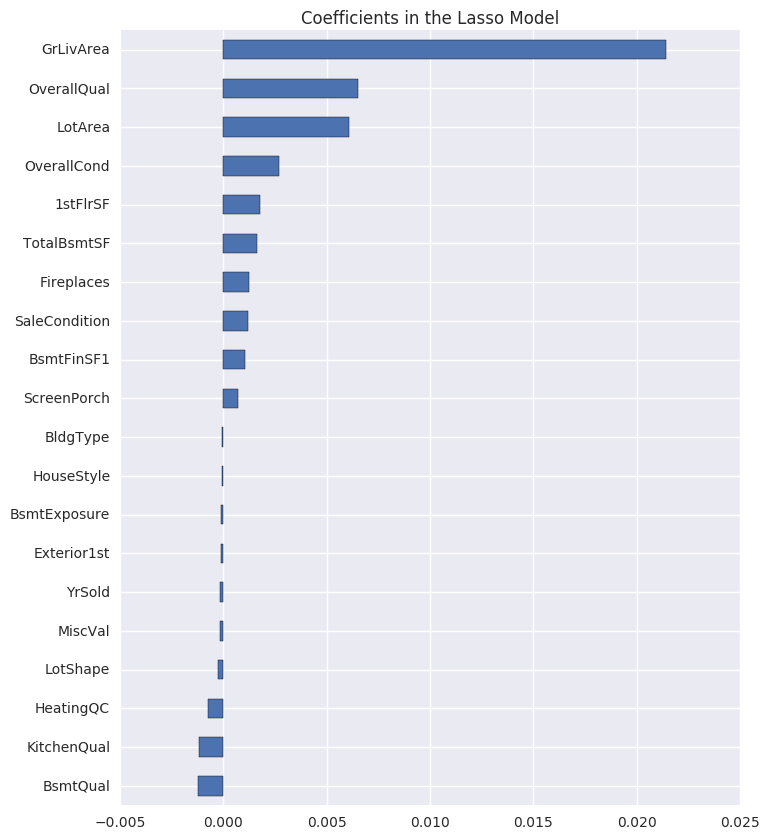

In [25]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [26]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(train_final), "true":log_y})
preds["residuals"] = preds["true"] - preds["preds"]
#preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [27]:
dtrain = xgb.DMatrix(train_final, label = log_y)
dtest = xgb.DMatrix(test_final)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

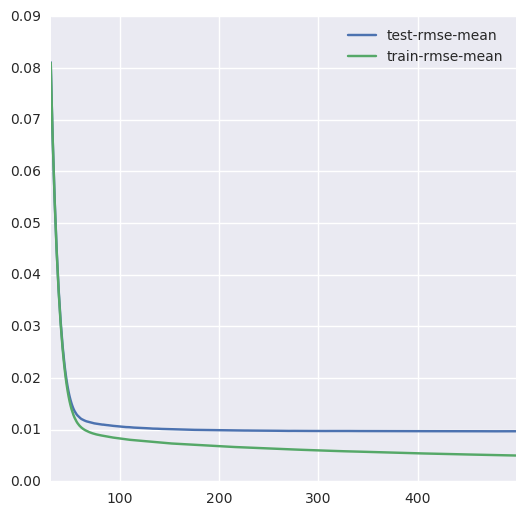

In [28]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [29]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(train_final, log_y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)